# Titanic Survival Prediction

This notebook predicts the probability of survival in a titanic based on the dataset.

# Import Libraries and Setup

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats
from scipy.stats import chi2_contingency, jarque_bera, normaltest
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer, QuantileTransformer, LabelEncoder, OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_classif, RFE, SelectFromModel
from sklearn.linear_model import LogisticRegression, Ridge, Lasso, ElasticNet, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
from sklearn.inspection import permutation_importance
import joblib
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
np.random.seed(42)

# Data Loading and Initial Exploration

In [26]:
url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
df = pd.read_csv(url)

print(f"Dataset Shape: {df.shape}")
print(f"Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print("\nDataset Info:")
df.info()
print("\nFirst 5 rows:")
df.head()

Dataset Shape: (891, 12)
Memory Usage: 0.31 MB

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB

First 5 rows:


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Data Quality Assessment

In [27]:
missing_data = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': df.isnull().sum(),
    'Missing_Percentage': (df.isnull().sum() / len(df)) * 100,
    'Data_Type': df.dtypes
})
missing_data = missing_data[missing_data['Missing_Count'] > 0].sort_values('Missing_Percentage', ascending=False)

duplicates = df.duplicated().sum()
print(f"Duplicate rows: {duplicates}")

print("\nStatistical Summary:")
df.describe(include='all')

Duplicate rows: 0

Statistical Summary:


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Dooley, Mr. Patrick",male,NaN,NaN,NaN,347082,NaN,G6,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


# Target Variable Analysis and Statistical Tests

In [28]:
survival_counts = df['Survived'].value_counts()
survival_rate = df['Survived'].mean()

print(f"Survival Rate: {survival_rate:.3f}")
print(f"Class Distribution: {survival_counts.to_dict()}")

categorical_features = ['Sex', 'Pclass', 'Embarked']
chi_square_results = {}

for feature in categorical_features:
    if df[feature].notna().sum() > 0:
        contingency_table = pd.crosstab(df[feature], df['Survived'])
        chi2, p_value, dof, expected = chi2_contingency(contingency_table)
        chi_square_results[feature] = {'chi2': chi2, 'p_value': p_value}

print("\nChi-square test results:")
for feature, results in chi_square_results.items():
    print(f"{feature}: Chi2={results['chi2']:.4f}, p-value={results['p_value']:.6f}")

Survival Rate: 0.384
Class Distribution: {0: 549, 1: 342}

Chi-square test results:
Sex: Chi2=260.7170, p-value=0.000000
Pclass: Chi2=102.8890, p-value=0.000000
Embarked: Chi2=26.4891, p-value=0.000002


# Feature Engineering

In [29]:
df_engineered = df.copy()

df_engineered['FamilySize'] = df_engineered['SibSp'] + df_engineered['Parch'] + 1
df_engineered['IsAlone'] = (df_engineered['FamilySize'] == 1).astype(int)
df_engineered['SmallFamily'] = (df_engineered['FamilySize'].between(2, 4)).astype(int)
df_engineered['LargeFamily'] = (df_engineered['FamilySize'] > 4).astype(int)

df_engineered['Title'] = df_engineered['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
title_mapping = {'Mr': 1, 'Miss': 2, 'Mrs': 3, 'Master': 4, 'Dr': 5, 'Rev': 6, 'Col': 7, 'Major': 7, 'Mlle': 2, 'Countess': 8, 'Ms': 2, 'Lady': 8, 'Jonkheer': 8, 'Don': 8, 'Dona': 8, 'Mme': 3, 'Capt': 7, 'Sir': 8}
df_engineered['Title'] = df_engineered['Title'].map(title_mapping).fillna(0)

df_engineered['Age'].fillna(df_engineered.groupby(['Pclass', 'Sex'])['Age'].transform('median'), inplace=True)
df_engineered['AgeGroup'] = pd.cut(df_engineered['Age'], bins=[0, 12, 18, 35, 60, 100], labels=[1, 2, 3, 4, 5])
df_engineered['IsChild'] = (df_engineered['Age'] < 16).astype(int)
df_engineered['IsElderly'] = (df_engineered['Age'] >= 60).astype(int)

df_engineered['Fare'].fillna(df_engineered['Fare'].median(), inplace=True)
df_engineered['FareGroup'] = pd.qcut(df_engineered['Fare'], q=5, labels=[1, 2, 3, 4, 5])
df_engineered['FarePerPerson'] = df_engineered['Fare'] / df_engineered['FamilySize']

df_engineered['CabinKnown'] = df_engineered['Cabin'].notna().astype(int)
df_engineered['CabinDeck'] = df_engineered['Cabin'].str[0]
deck_mapping = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'T': 8}
df_engineered['CabinDeck'] = df_engineered['CabinDeck'].map(deck_mapping).fillna(0)

df_engineered['Embarked'].fillna(df_engineered['Embarked'].mode()[0], inplace=True)
embarked_mapping = {'S': 1, 'C': 2, 'Q': 3}
df_engineered['Embarked_Encoded'] = df_engineered['Embarked'].map(embarked_mapping)

df_engineered['Sex_Encoded'] = df_engineered['Sex'].map({'male': 0, 'female': 1})

df_engineered['Age_Pclass'] = df_engineered['Age'] * df_engineered['Pclass']
df_engineered['Fare_Age'] = df_engineered['Fare'] * df_engineered['Age']
df_engineered['Sex_Age'] = df_engineered['Sex_Encoded'] * df_engineered['Age']
df_engineered['Title_Age'] = df_engineered['Title'] * df_engineered['Age']

print(f"Engineered dataset shape: {df_engineered.shape}")

Engineered dataset shape: (891, 30)


# Polynomial Features and Advanced Transformations

In [30]:
from sklearn.preprocessing import PolynomialFeatures

numerical_features = ['Age', 'Fare', 'FamilySize', 'FarePerPerson']
numerical_data = df_engineered[numerical_features]

poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
poly_features = poly.fit_transform(numerical_data)
poly_feature_names = poly.get_feature_names_out(numerical_features)

poly_df = pd.DataFrame(poly_features, columns=poly_feature_names, index=df_engineered.index)

feature_columns = ['Survived', 'Pclass', 'Sex_Encoded', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked_Encoded',
                  'FamilySize', 'IsAlone', 'SmallFamily', 'LargeFamily', 'Title', 'AgeGroup',
                  'IsChild', 'IsElderly', 'FareGroup', 'FarePerPerson', 'CabinKnown', 'CabinDeck',
                  'Age_Pclass', 'Fare_Age', 'Sex_Age', 'Title_Age']

df_final = df_engineered[feature_columns].copy()

selected_poly = ['Age^2', 'Fare^2', 'FamilySize^2', 'Age Fare', 'Age FamilySize']
for feature in selected_poly:
    if feature in poly_df.columns:
        df_final[f'Poly_{feature.replace(" ", "_").replace("^", "_pow")}'] = poly_df[feature]

print(f"Final feature set shape: {df_final.shape}")

Final feature set shape: (891, 29)


# Data Visualization Dashboard

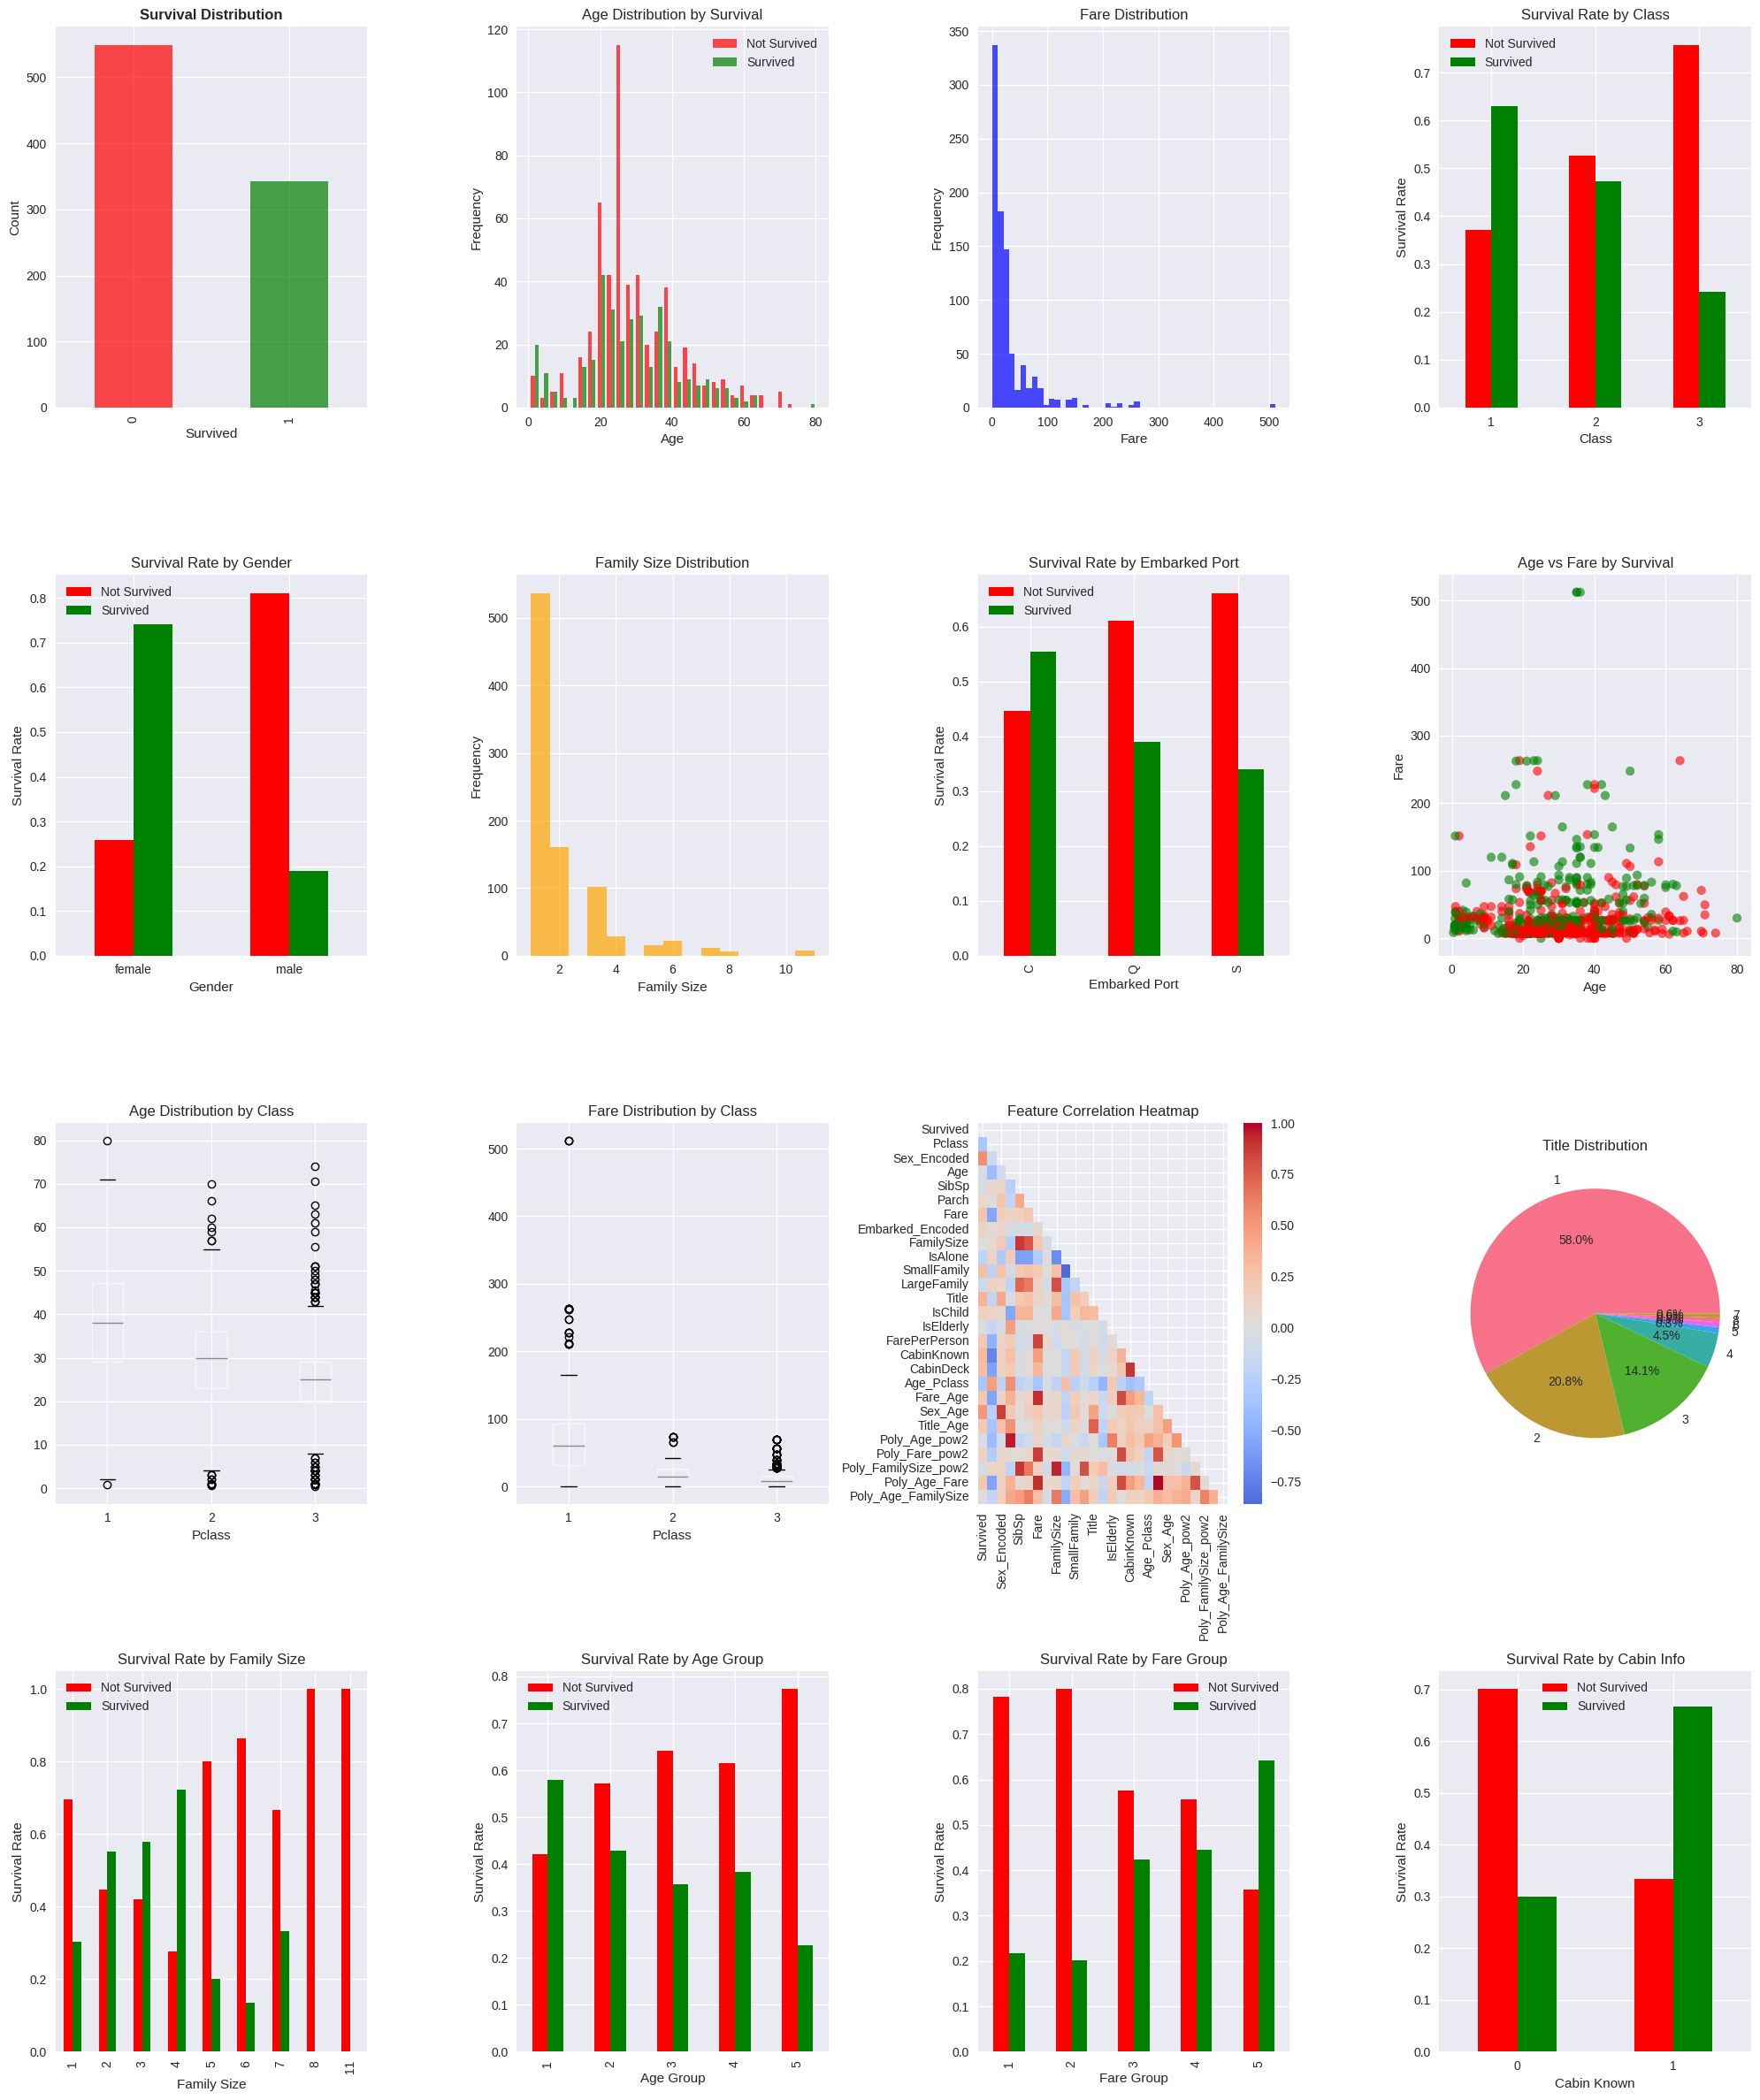

In [31]:
fig = plt.figure(figsize=(20, 24))

plt.subplot(4, 4, 1)
survival_counts.plot(kind='bar', color=['red', 'green'], alpha=0.7)
plt.title('Survival Distribution', fontsize=12, fontweight='bold')
plt.xlabel('Survived')
plt.ylabel('Count')

plt.subplot(4, 4, 2)
plt.hist([df_engineered[df_engineered['Survived']==0]['Age'],
          df_engineered[df_engineered['Survived']==1]['Age']],
         bins=30, alpha=0.7, label=['Not Survived', 'Survived'], color=['red', 'green'])
plt.title('Age Distribution by Survival')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(4, 4, 3)
plt.hist(df_engineered['Fare'], bins=50, alpha=0.7, color='blue')
plt.title('Fare Distribution')
plt.xlabel('Fare')
plt.ylabel('Frequency')

plt.subplot(4, 4, 4)
class_survival = pd.crosstab(df_engineered['Pclass'], df_engineered['Survived'], normalize='index')
class_survival.plot(kind='bar', ax=plt.gca(), color=['red', 'green'])
plt.title('Survival Rate by Class')
plt.xlabel('Class')
plt.ylabel('Survival Rate')
plt.legend(['Not Survived', 'Survived'])
plt.xticks(rotation=0)

plt.subplot(4, 4, 5)
gender_survival = pd.crosstab(df_engineered['Sex'], df_engineered['Survived'], normalize='index')
gender_survival.plot(kind='bar', ax=plt.gca(), color=['red', 'green'])
plt.title('Survival Rate by Gender')
plt.xlabel('Gender')
plt.ylabel('Survival Rate')
plt.legend(['Not Survived', 'Survived'])
plt.xticks(rotation=0)

plt.subplot(4, 4, 6)
df_engineered['FamilySize'].hist(bins=15, alpha=0.7, color='orange')
plt.title('Family Size Distribution')
plt.xlabel('Family Size')
plt.ylabel('Frequency')

plt.subplot(4, 4, 7)
embarked_survival = pd.crosstab(df_engineered['Embarked'], df_engineered['Survived'], normalize='index')
embarked_survival.plot(kind='bar', ax=plt.gca(), color=['red', 'green'])
plt.title('Survival Rate by Embarked Port')
plt.xlabel('Embarked Port')
plt.ylabel('Survival Rate')
plt.legend(['Not Survived', 'Survived'])

plt.subplot(4, 4, 8)
colors = ['red' if x == 0 else 'green' for x in df_engineered['Survived']]
plt.scatter(df_engineered['Age'], df_engineered['Fare'], c=colors, alpha=0.6)
plt.title('Age vs Fare by Survival')
plt.xlabel('Age')
plt.ylabel('Fare')

plt.subplot(4, 4, 9)
df_engineered.boxplot(column='Age', by='Pclass', ax=plt.gca())
plt.title('Age Distribution by Class')
plt.suptitle('')

plt.subplot(4, 4, 10)
df_engineered.boxplot(column='Fare', by='Pclass', ax=plt.gca())
plt.title('Fare Distribution by Class')
plt.suptitle('')

plt.subplot(4, 4, 11)
numerical_cols = df_final.select_dtypes(include=[np.number]).columns
corr_matrix = df_final[numerical_cols].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='coolwarm', center=0, ax=plt.gca())
plt.title('Feature Correlation Heatmap')

plt.subplot(4, 4, 12)
title_counts = df_engineered['Title'].value_counts()
plt.pie(title_counts.values, labels=title_counts.index, autopct='%1.1f%%')
plt.title('Title Distribution')

plt.subplot(4, 4, 13)
family_survival = pd.crosstab(df_engineered['FamilySize'], df_engineered['Survived'], normalize='index')
family_survival.plot(kind='bar', ax=plt.gca(), color=['red', 'green'])
plt.title('Survival Rate by Family Size')
plt.xlabel('Family Size')
plt.ylabel('Survival Rate')
plt.legend(['Not Survived', 'Survived'])

plt.subplot(4, 4, 14)
agegroup_survival = pd.crosstab(df_engineered['AgeGroup'], df_engineered['Survived'], normalize='index')
agegroup_survival.plot(kind='bar', ax=plt.gca(), color=['red', 'green'])
plt.title('Survival Rate by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Survival Rate')
plt.legend(['Not Survived', 'Survived'])

plt.subplot(4, 4, 15)
faregroup_survival = pd.crosstab(df_engineered['FareGroup'], df_engineered['Survived'], normalize='index')
faregroup_survival.plot(kind='bar', ax=plt.gca(), color=['red', 'green'])
plt.title('Survival Rate by Fare Group')
plt.xlabel('Fare Group')
plt.ylabel('Survival Rate')
plt.legend(['Not Survived', 'Survived'])

plt.subplot(4, 4, 16)
cabin_survival = pd.crosstab(df_engineered['CabinKnown'], df_engineered['Survived'], normalize='index')
cabin_survival.plot(kind='bar', ax=plt.gca(), color=['red', 'green'])
plt.title('Survival Rate by Cabin Info')
plt.xlabel('Cabin Known')
plt.ylabel('Survival Rate')
plt.legend(['Not Survived', 'Survived'])
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

# Feature Selection and Importance Analysis


Top 15 features by Random Forest importance:
                feature  importance
21              Sex_Age    0.110914
11                Title    0.082668
22            Title_Age    0.075305
19           Age_Pclass    0.068448
16        FarePerPerson    0.067732
1           Sex_Encoded    0.066366
26        Poly_Age_Fare    0.060968
20             Fare_Age    0.055288
24       Poly_Fare_pow2    0.050912
5                  Fare    0.049924
2                   Age    0.041984
23        Poly_Age_pow2    0.041242
27  Poly_Age_FamilySize    0.039879
0                Pclass    0.036281
18            CabinDeck    0.022853


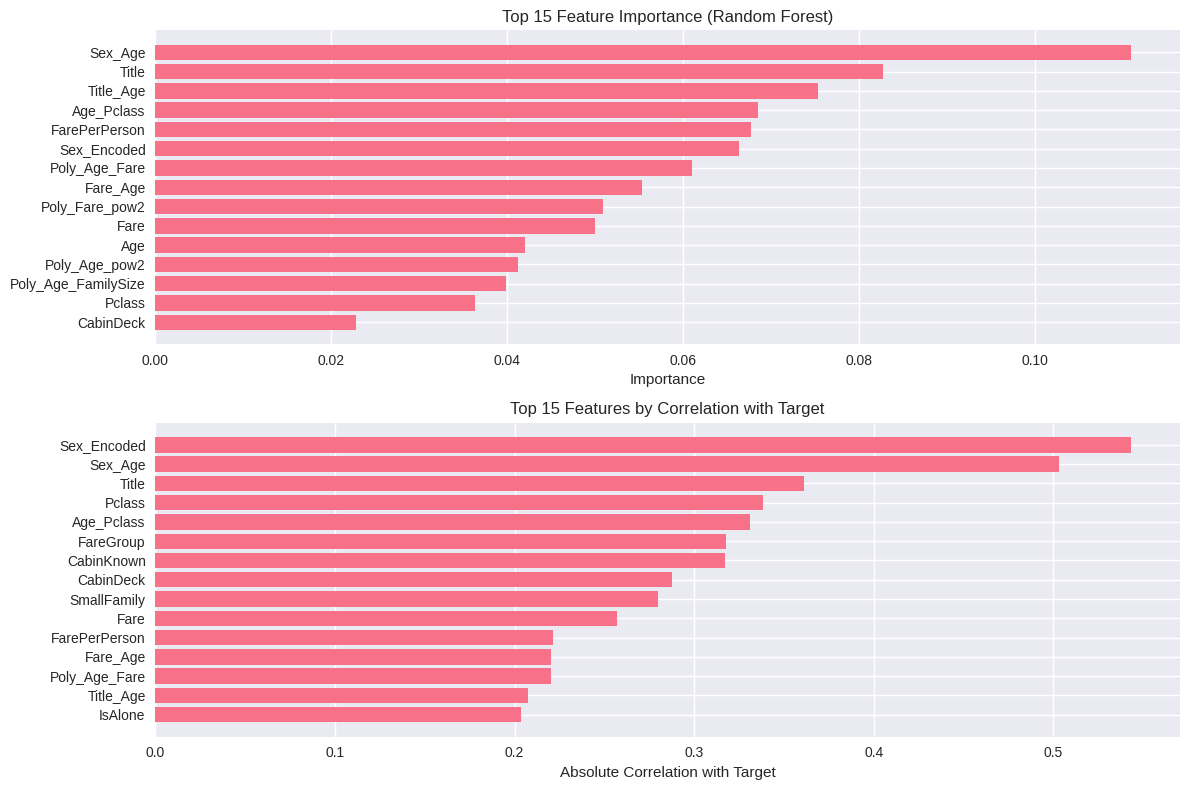

In [32]:
X = df_final.drop(['Survived'], axis=1)
y = df_final['Survived']

numerical_cols = X.select_dtypes(include=np.number).columns
categorical_cols = X.select_dtypes(include='category').columns

X[numerical_cols] = X[numerical_cols].fillna(X[numerical_cols].median())

for col in categorical_cols:
    X[col] = X[col].fillna(X[col].mode()[0])


selector_univariate = SelectKBest(score_func=f_classif, k=15)
X_selected_univariate = selector_univariate.fit_transform(X, y)
selected_features_univariate = X.columns[selector_univariate.get_support()].tolist()

rf_selector = RandomForestClassifier(n_estimators=100, random_state=42)
rf_selector.fit(X, y)
feature_importance_rf = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_selector.feature_importances_
}).sort_values('importance', ascending=False)

rfe_selector = RFE(LogisticRegression(random_state=42), n_features_to_select=15)
rfe_selector.fit(X, y)
selected_features_rfe = X.columns[rfe_selector.support_].tolist()

print("Top 15 features by Random Forest importance:")
print(feature_importance_rf.head(15))

plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
top_features = feature_importance_rf.head(15)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance')
plt.title('Top 15 Feature Importance (Random Forest)')
plt.gca().invert_yaxis()

plt.subplot(2, 1, 2)
target_corr = X.corrwith(y).abs().sort_values(ascending=False).head(15)
plt.barh(range(len(target_corr)), target_corr.values)
plt.yticks(range(len(target_corr)), target_corr.index)
plt.xlabel('Absolute Correlation with Target')
plt.title('Top 15 Features by Correlation with Target')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

top_features = feature_importance_rf.head(20)['feature'].tolist()
X_final = X[top_features]

# Multiple Preprocessing Pipelines

In [33]:
preprocessing_pipelines = {}

scaler_standard = StandardScaler()
X_standard = scaler_standard.fit_transform(X_final)
preprocessing_pipelines['StandardScaler'] = (X_standard, scaler_standard)

scaler_minmax = MinMaxScaler()
X_minmax = scaler_minmax.fit_transform(X_final)
preprocessing_pipelines['MinMaxScaler'] = (X_minmax, scaler_minmax)

scaler_robust = RobustScaler()
X_robust = scaler_robust.fit_transform(X_final)
preprocessing_pipelines['RobustScaler'] = (X_robust, scaler_robust)

transformer_power = PowerTransformer(method='yeo-johnson')
X_power = transformer_power.fit_transform(X_final)
preprocessing_pipelines['PowerTransformer'] = (X_power, transformer_power)

transformer_quantile = QuantileTransformer(output_distribution='normal', random_state=42)
X_quantile = transformer_quantile.fit_transform(X_final)
preprocessing_pipelines['QuantileTransformer'] = (X_quantile, transformer_quantile)

print("Preprocessing pipelines created:")
for name in preprocessing_pipelines.keys():
    print(f"- {name}")

train_test_splits = {}
for name, (X_processed, scaler) in preprocessing_pipelines.items():
    X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42, stratify=y)
    train_test_splits[name] = (X_train, X_test, y_train, y_test)

Preprocessing pipelines created:
- StandardScaler
- MinMaxScaler
- RobustScaler
- PowerTransformer
- QuantileTransformer


# Model Definition and Hyperparameter Grids

In [37]:
models_config = {
    'LogisticRegression': {
        'model': LogisticRegression(random_state=42, max_iter=1000),
        'params': {
            'C': [0.01, 0.1, 1, 10, 100],
            'penalty': ['l1', 'l2'],
            'solver': ['liblinear', 'saga'],
            'l1_ratio': [0.3, 0.5, 0.7]
        }
    },
    'RidgeClassifier': {
        'model': RidgeClassifier(random_state=42),
        'params': {
            'alpha': [0.01, 0.1, 1, 10, 100],
            'solver': ['auto', 'svd', 'cholesky']
        }
    },
    'DecisionTree': {
        'model': DecisionTreeClassifier(random_state=42),
        'params': {
            'max_depth': [3, 5, 10, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'criterion': ['gini', 'entropy'],
            'max_features': ['sqrt', 'log2']
        }
    },
    'RandomForest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [3, 5, 10, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['sqrt', 'log2'],
            'bootstrap': [True]
        }
    },
    'GradientBoosting': {
        'model': GradientBoostingClassifier(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 4, 5],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2],
            'subsample': [0.8, 1.0]
        }
    },
    'AdaBoost': {
        'model': AdaBoostClassifier(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.5, 1.0],
            'algorithm': ['SAMME']
        }
    },
    'SVM': {
        'model': SVC(random_state=42, probability=True),
        'params': {
            'C': [0.1, 1, 10, 100],
            'kernel': ['rbf', 'poly'],
            'gamma': ['scale', 'auto', 0.01, 0.1],
            'degree': [2, 3]
        }
    },
    'KNN': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [3, 5, 7, 9, 11],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan'],
            'p': [2]
        }
    },
    'MLP': {
        'model': MLPClassifier(random_state=42, max_iter=1000),
        'params': {
            'hidden_layer_sizes': [(50,), (100,), (100, 50)],
            'activation': ['relu', 'tanh'],
            'solver': ['adam'],
            'alpha': [0.0001, 0.001, 0.01],
            'learning_rate': ['constant', 'adaptive']
        }
    }
}

print(f"Total models configured: {len(models_config)}")
print("Models:", list(models_config.keys()))

Total models configured: 9
Models: ['LogisticRegression', 'RidgeClassifier', 'DecisionTree', 'RandomForest', 'GradientBoosting', 'AdaBoost', 'SVM', 'KNN', 'MLP']


# Model Training and Hyperparameter Optimization

In [38]:
cv_folds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
model_results = {}
best_models = {}

for preprocessing_name, (X_train, X_test, y_train, y_test) in train_test_splits.items():
    print(f"\nTraining models with {preprocessing_name}:")
    preprocessing_results = {}

    for model_name, config in models_config.items():
        print(f"  Training {model_name}...")

        try:
            random_search = RandomizedSearchCV(
                estimator=config['model'],
                param_distributions=config['params'],
                scoring='roc_auc',
                cv=cv_folds,
                n_iter=20,
                random_state=42,
                n_jobs=-1
            )

            random_search.fit(X_train, y_train)

            best_model = random_search.best_estimator_
            y_pred = best_model.predict(X_test)
            y_pred_proba = best_model.predict_proba(X_test)[:, 1] if hasattr(best_model, 'predict_proba') else y_pred

            metrics = {
                'accuracy': accuracy_score(y_test, y_pred),
                'precision': precision_score(y_test, y_pred),
                'recall': recall_score(y_test, y_pred),
                'f1': f1_score(y_test, y_pred),
                'roc_auc': roc_auc_score(y_test, y_pred_proba),
                'cv_score_mean': random_search.best_score_,
                'cv_score_std': random_search.cv_results_['std_test_score'][random_search.best_index_],
                'best_params': random_search.best_params_
            }

            preprocessing_results[model_name] = {
                'model': best_model,
                'metrics': metrics,
                'predictions': {'y_true': y_test, 'y_pred': y_pred, 'y_pred_proba': y_pred_proba}
            }

        except Exception as e:
            print(f"    Error training {model_name}: {str(e)}")
            continue

    model_results[preprocessing_name] = preprocessing_results

best_overall_score = 0
best_overall_config = None

for prep_name, prep_results in model_results.items():
    for model_name, model_data in prep_results.items():
        current_score = model_data['metrics']['roc_auc']
        if current_score > best_overall_score:
            best_overall_score = current_score
            best_overall_config = (prep_name, model_name, model_data)

print(f"\nBest overall model: {best_overall_config[1]} with {best_overall_config[0]}")
print(f"Best ROC-AUC: {best_overall_score:.4f}")


Training models with StandardScaler:
  Training LogisticRegression...
  Training RidgeClassifier...
  Training DecisionTree...
  Training RandomForest...
  Training GradientBoosting...
  Training AdaBoost...
  Training SVM...
  Training KNN...
  Training MLP...

Training models with MinMaxScaler:
  Training LogisticRegression...
  Training RidgeClassifier...
  Training DecisionTree...
  Training RandomForest...
  Training GradientBoosting...
  Training AdaBoost...
  Training SVM...
  Training KNN...
  Training MLP...

Training models with RobustScaler:
  Training LogisticRegression...
  Training RidgeClassifier...
  Training DecisionTree...
  Training RandomForest...
  Training GradientBoosting...
  Training AdaBoost...
  Training SVM...
  Training KNN...
  Training MLP...

Training models with PowerTransformer:
  Training LogisticRegression...
  Training RidgeClassifier...
  Training DecisionTree...
  Training RandomForest...
  Training GradientBoosting...
  Training AdaBoost...
  Tr

# Model Performance Comparison and Analysis

Top 10 Model Performances:
          Preprocessing               Model  Accuracy  Precision  Recall  \
22         RobustScaler    GradientBoosting    0.8268     0.8065  0.7246   
13         MinMaxScaler    GradientBoosting    0.8268     0.8065  0.7246   
40  QuantileTransformer    GradientBoosting    0.8212     0.7846  0.7391   
4        StandardScaler    GradientBoosting    0.8268     0.8065  0.7246   
18         RobustScaler  LogisticRegression    0.8101     0.7612  0.7391   
31     PowerTransformer    GradientBoosting    0.8156     0.7812  0.7246   
6        StandardScaler                 SVM    0.8101     0.7869  0.6957   
17         MinMaxScaler                 MLP    0.8101     0.7692  0.7246   
15         MinMaxScaler                 SVM    0.7933     0.8200  0.5942   
39  QuantileTransformer        RandomForest    0.8101     0.7778  0.7101   

    F1-Score  ROC-AUC  CV_Mean  CV_Std  
22    0.7634   0.8659   0.8810  0.0102  
13    0.7634   0.8601   0.8812  0.0055  
40    0.7612 

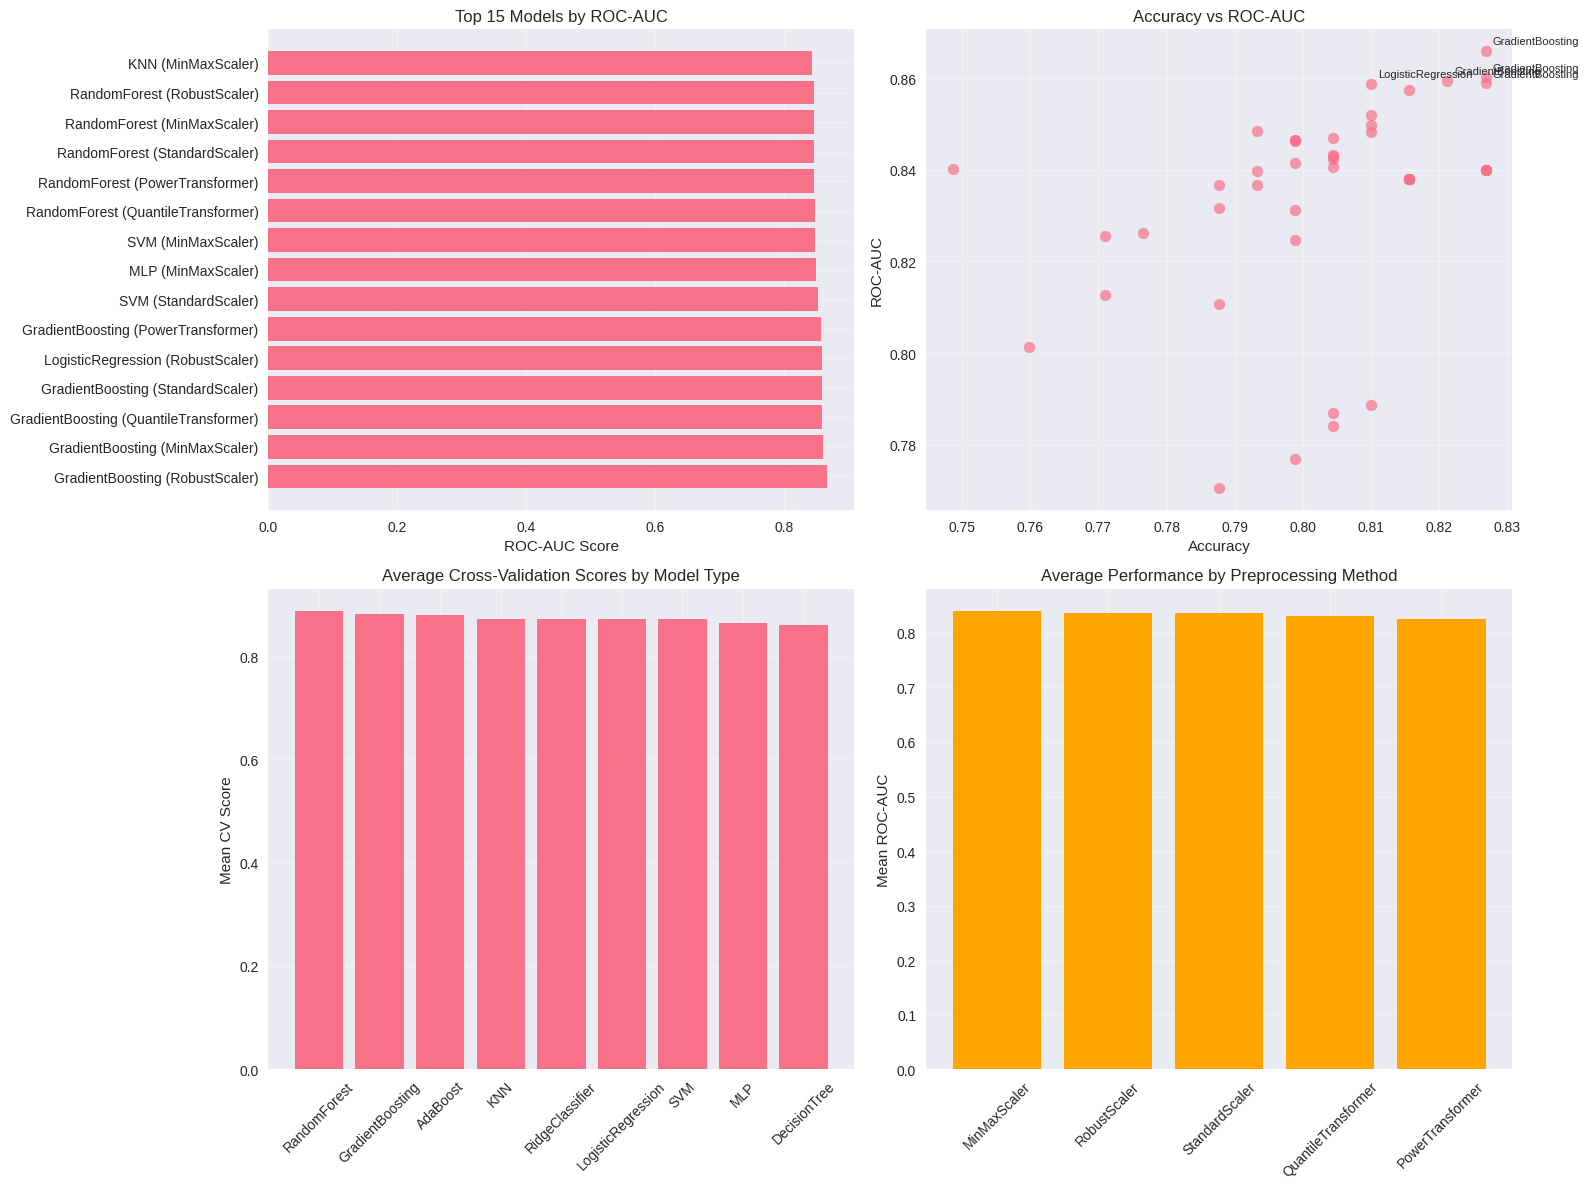


Statistical Analysis of Model Performance:
Mean ROC-AUC: 0.8340
Standard Deviation: 0.0227
Best ROC-AUC: 0.8659
Worst ROC-AUC: 0.7706

Model Type Performance Summary:
                   ROC-AUC                         Accuracy         F1-Score  \
                      mean     std     max     min     mean     std     mean   
Model                                                                          
AdaBoost            0.8380  0.0000  0.8380  0.8380   0.8156  0.0000   0.7519   
DecisionTree        0.8323  0.0172  0.8400  0.8014   0.8134  0.0300   0.7555   
GradientBoosting    0.8603  0.0033  0.8659  0.8574   0.8235  0.0050   0.7606   
KNN                 0.8358  0.0091  0.8433  0.8256   0.7911  0.0161   0.7099   
LogisticRegression  0.8427  0.0099  0.8586  0.8316   0.8000  0.0092   0.7246   
MLP                 0.8258  0.0158  0.8497  0.8108   0.7933  0.0148   0.7154   
RandomForest        0.8469  0.0008  0.8482  0.8463   0.8022  0.0050   0.7347   
RidgeClassifier     0.7815  0.00

In [40]:
comparison_results = []

for prep_name, prep_results in model_results.items():
    for model_name, model_data in prep_results.items():
        metrics = model_data['metrics']
        comparison_results.append({
            'Preprocessing': prep_name,
            'Model': model_name,
            'Accuracy': metrics['accuracy'],
            'Precision': metrics['precision'],
            'Recall': metrics['recall'],
            'F1-Score': metrics['f1'],
            'ROC-AUC': metrics['roc_auc'],
            'CV_Mean': metrics['cv_score_mean'],
            'CV_Std': metrics['cv_score_std']
        })

results_df = pd.DataFrame(comparison_results)
results_df = results_df.sort_values('ROC-AUC', ascending=False)

print("Top 10 Model Performances:")
print(results_df.head(10).round(4))

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

top_15 = results_df.head(15)
axes[0, 0].barh(range(len(top_15)), top_15['ROC-AUC'])
axes[0, 0].set_yticks(range(len(top_15)))
axes[0, 0].set_yticklabels([f"{row['Model']} ({row['Preprocessing']})" for _, row in top_15.iterrows()])
axes[0, 0].set_xlabel('ROC-AUC Score')
axes[0, 0].set_title('Top 15 Models by ROC-AUC')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].scatter(results_df['Accuracy'], results_df['ROC-AUC'], alpha=0.7, s=60)
for i, (_, row) in enumerate(results_df.head(5).iterrows()):
    axes[0, 1].annotate(f"{row['Model']}", (row['Accuracy'], row['ROC-AUC']),
                       xytext=(5, 5), textcoords='offset points', fontsize=8)
axes[0, 1].set_xlabel('Accuracy')
axes[0, 1].set_ylabel('ROC-AUC')
axes[0, 1].set_title('Accuracy vs ROC-AUC')
axes[0, 1].grid(True, alpha=0.3)

model_cv_scores = results_df.groupby('Model')['CV_Mean'].mean().sort_values(ascending=False)
axes[1, 0].bar(range(len(model_cv_scores)), model_cv_scores.values)
axes[1, 0].set_xticks(range(len(model_cv_scores)))
axes[1, 0].set_xticklabels(model_cv_scores.index, rotation=45)
axes[1, 0].set_ylabel('Mean CV Score')
axes[1, 0].set_title('Average Cross-Validation Scores by Model Type')
axes[1, 0].grid(True, alpha=0.3)

prep_scores = results_df.groupby('Preprocessing')['ROC-AUC'].mean().sort_values(ascending=False)
axes[1, 1].bar(range(len(prep_scores)), prep_scores.values, color='orange')
axes[1, 1].set_xticks(range(len(prep_scores)))
axes[1, 1].set_xticklabels(prep_scores.index, rotation=45)
axes[1, 1].set_ylabel('Mean ROC-AUC')
axes[1, 1].set_title('Average Performance by Preprocessing Method')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nStatistical Analysis of Model Performance:")
print(f"Mean ROC-AUC: {results_df['ROC-AUC'].mean():.4f}")
print(f"Standard Deviation: {results_df['ROC-AUC'].std():.4f}")
print(f"Best ROC-AUC: {results_df['ROC-AUC'].max():.4f}")
print(f"Worst ROC-AUC: {results_df['ROC-AUC'].min():.4f}")

model_performance = results_df.groupby('Model').agg({
    'ROC-AUC': ['mean', 'std', 'max', 'min'],
    'Accuracy': ['mean', 'std'],
    'F1-Score': ['mean', 'std']
}).round(4)

print("\nModel Type Performance Summary:")
print(model_performance)

# Advanced Model Ensemble and Stacking

In [42]:
best_prep_method = best_overall_config[0]
X_train, X_test, y_train, y_test = train_test_splits[best_prep_method]

top_models = results_df.head(5)
ensemble_models = []
ensemble_names = []

for _, row in top_models.iterrows():
    if row['Preprocessing'] == best_prep_method:
        model_data = model_results[row['Preprocessing']][row['Model']]
        ensemble_models.append((row['Model'], model_data['model']))
        ensemble_names.append(row['Model'])

voting_results = {}
if len(ensemble_models) >= 3:
    voting_hard = VotingClassifier(estimators=ensemble_models[:3], voting='hard')
    voting_soft = VotingClassifier(estimators=ensemble_models[:3], voting='soft')

    voting_hard.fit(X_train, y_train)
    voting_soft.fit(X_train, y_train)

    hard_pred = voting_hard.predict(X_test)
    soft_pred = voting_soft.predict(X_test)
    soft_pred_proba = voting_soft.predict_proba(X_test)[:, 1]

    voting_results = {
        'Hard Voting': {
            'accuracy': accuracy_score(y_test, hard_pred),
            'f1': f1_score(y_test, hard_pred),
            'roc_auc': roc_auc_score(y_test, hard_pred)
        },
        'Soft Voting': {
            'accuracy': accuracy_score(y_test, soft_pred),
            'f1': f1_score(y_test, soft_pred),
            'roc_auc': roc_auc_score(y_test, soft_pred_proba)
        }
    }

stacking_results = {}
if len(ensemble_models) >= 2:
    stacking_clf = StackingClassifier(
        estimators=ensemble_models[:4],
        final_estimator=LogisticRegression(random_state=42),
        cv=5
    )

    stacking_clf.fit(X_train, y_train)
    stack_pred = stacking_clf.predict(X_test)
    stack_pred_proba = stacking_clf.predict_proba(X_test)[:, 1]

    stacking_results = {
        'accuracy': accuracy_score(y_test, stack_pred),
        'precision': precision_score(y_test, stack_pred),
        'recall': recall_score(y_test, stack_pred),
        'f1': f1_score(y_test, stack_pred),
        'roc_auc': roc_auc_score(y_test, stack_pred_proba)
    }

weights = np.array([0.3, 0.25, 0.2, 0.15, 0.1])
ensemble_predictions = np.zeros((len(X_test), len(ensemble_models)))

for i, (name, model) in enumerate(ensemble_models):
    if hasattr(model, 'predict_proba'):
        ensemble_predictions[:, i] = model.predict_proba(X_test)[:, 1]
    else:
        ensemble_predictions[:, i] = model.predict(X_test)

weighted_pred_proba = np.average(ensemble_predictions, weights=weights[:len(ensemble_models)], axis=1)
weighted_pred = (weighted_pred_proba > 0.5).astype(int)

weighted_results = {
    'accuracy': accuracy_score(y_test, weighted_pred),
    'precision': precision_score(y_test, weighted_pred),
    'recall': recall_score(y_test, weighted_pred),
    'f1': f1_score(y_test, weighted_pred),
    'roc_auc': roc_auc_score(y_test, weighted_pred_proba)
}

print("Ensemble Model Results:")
if voting_results:
    print("Voting Classifiers:")
    for method, metrics in voting_results.items():
        print(f"  {method}: Accuracy={metrics['accuracy']:.4f}, F1={metrics['f1']:.4f}, ROC-AUC={metrics['roc_auc']:.4f}")

if stacking_results:
    print(f"\nStacking Classifier:")
    print(f"  Accuracy={stacking_results['accuracy']:.4f}, Precision={stacking_results['precision']:.4f}")
    print(f"  Recall={stacking_results['recall']:.4f}, F1={stacking_results['f1']:.4f}, ROC-AUC={stacking_results['roc_auc']:.4f}")

print(f"\nWeighted Ensemble:")
print(f"  Accuracy={weighted_results['accuracy']:.4f}, Precision={weighted_results['precision']:.4f}")
print(f"  Recall={weighted_results['recall']:.4f}, F1={weighted_results['f1']:.4f}, ROC-AUC={weighted_results['roc_auc']:.4f}")

ensemble_comparison_data = {
    'Method': [],
    'Accuracy': [],
    'F1-Score': [],
    'ROC-AUC': []
}

if voting_results:
    ensemble_comparison_data['Method'].extend(['Hard Voting', 'Soft Voting'])
    ensemble_comparison_data['Accuracy'].extend([voting_results['Hard Voting']['accuracy'], voting_results['Soft Voting']['accuracy']])
    ensemble_comparison_data['F1-Score'].extend([voting_results['Hard Voting']['f1'], voting_results['Soft Voting']['f1']])
    ensemble_comparison_data['ROC-AUC'].extend([voting_results['Hard Voting']['roc_auc'], voting_results['Soft Voting']['roc_auc']])

if stacking_results:
    ensemble_comparison_data['Method'].append('Stacking')
    ensemble_comparison_data['Accuracy'].append(stacking_results['accuracy'])
    ensemble_comparison_data['F1-Score'].append(stacking_results['f1'])
    ensemble_comparison_data['ROC-AUC'].append(stacking_results['roc_auc'])

ensemble_comparison_data['Method'].append('Weighted Ensemble')
ensemble_comparison_data['Accuracy'].append(weighted_results['accuracy'])
ensemble_comparison_data['F1-Score'].append(weighted_results['f1'])
ensemble_comparison_data['ROC-AUC'].append(weighted_results['roc_auc'])


ensemble_comparison = pd.DataFrame(ensemble_comparison_data)

print("\nEnsemble Methods Comparison:")
print(ensemble_comparison.round(4))

Ensemble Model Results:

Stacking Classifier:
  Accuracy=0.8436, Precision=0.8475
  Recall=0.7246, F1=0.7812, ROC-AUC=0.8723

Weighted Ensemble:
  Accuracy=0.8380, Precision=0.8226
  Recall=0.7391, F1=0.7786, ROC-AUC=0.8711

Ensemble Methods Comparison:
              Method  Accuracy  F1-Score  ROC-AUC
0           Stacking    0.8436    0.7812   0.8723
1  Weighted Ensemble    0.8380    0.7786   0.8711


# ROC Curves and Performance Visualization

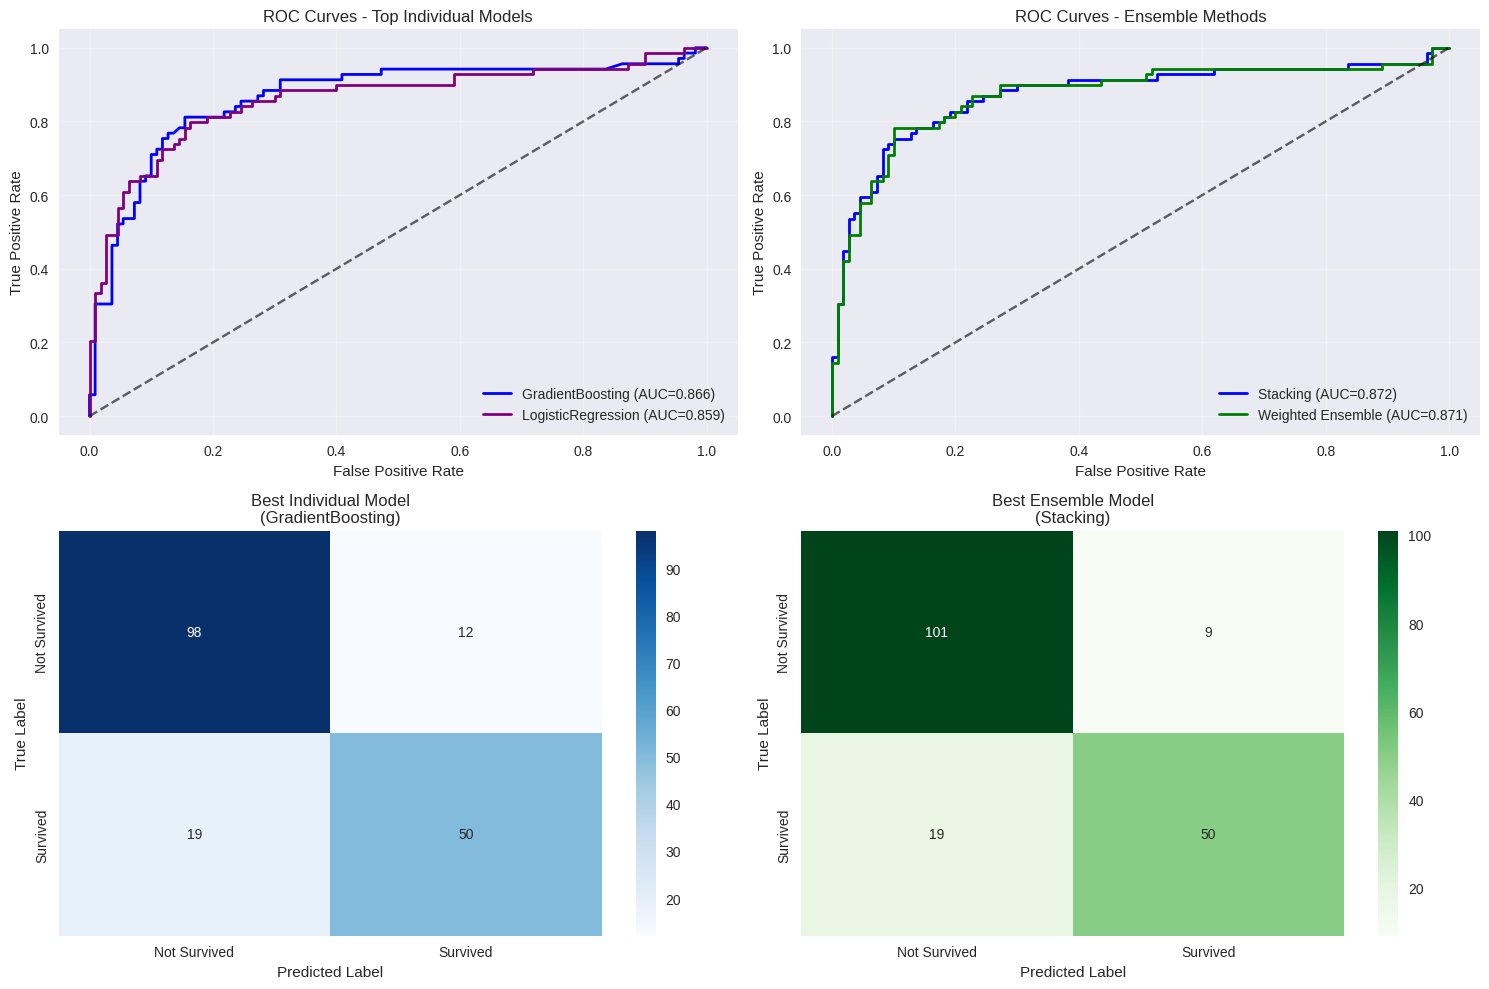

Classification Report - Best Individual Model:
              precision    recall  f1-score   support

Not Survived       0.84      0.89      0.86       110
    Survived       0.81      0.72      0.76        69

    accuracy                           0.83       179
   macro avg       0.82      0.81      0.81       179
weighted avg       0.83      0.83      0.82       179


Classification Report - Best Ensemble Model (Stacking):
              precision    recall  f1-score   support

Not Survived       0.84      0.92      0.88       110
    Survived       0.85      0.72      0.78        69

    accuracy                           0.84       179
   macro avg       0.84      0.82      0.83       179
weighted avg       0.84      0.84      0.84       179



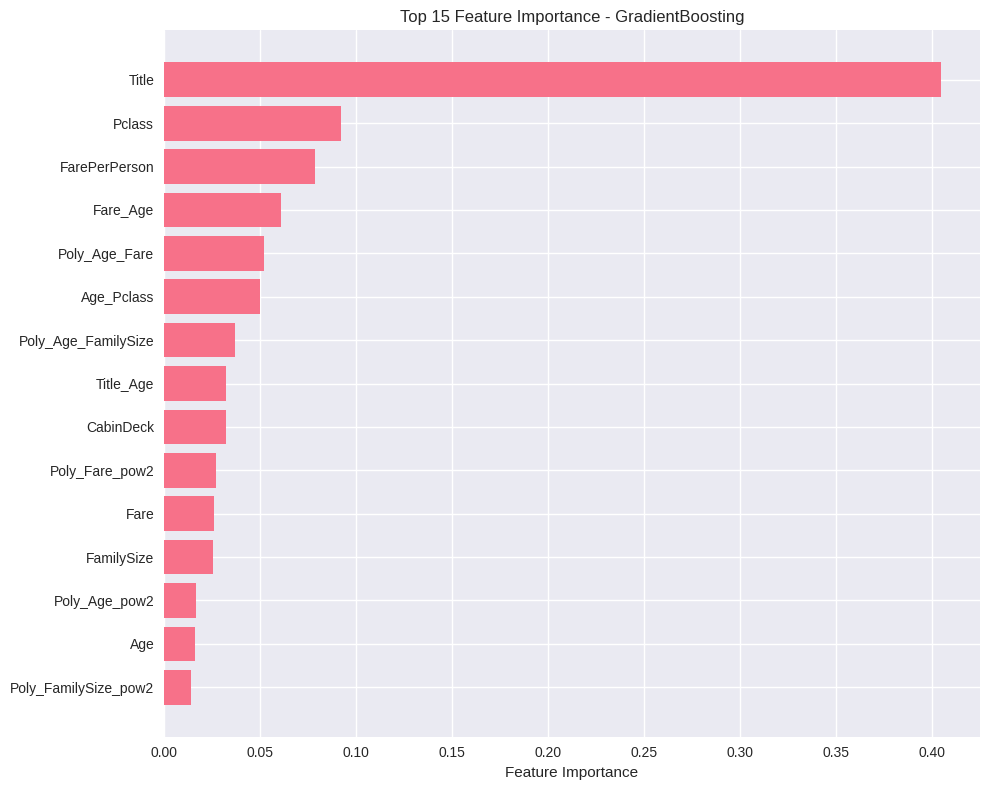

Top 10 Most Important Features:
                feature  importance
1                 Title    0.404752
13               Pclass    0.092334
4         FarePerPerson    0.078637
7              Fare_Age    0.060811
6         Poly_Age_Fare    0.052188
3            Age_Pclass    0.049895
12  Poly_Age_FamilySize    0.036829
2             Title_Age    0.032251
14            CabinDeck    0.032149
8        Poly_Fare_pow2    0.027351

Top 10 Features by Permutation Importance:
                 feature  importance_mean  importance_std
1                  Title         0.181006        0.026108
4          FarePerPerson         0.062570        0.016153
13                Pclass         0.040782        0.011995
6          Poly_Age_Fare         0.025698        0.005120
16            FamilySize         0.021788        0.005270
2              Title_Age         0.017877        0.006978
7               Fare_Age         0.015642        0.011665
3             Age_Pclass         0.013408        0.014611
0     

In [46]:
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

plt.figure(figsize=(15, 10))

colors = ['blue', 'green', 'red', 'orange', 'purple', 'brown', 'pink']
plt.subplot(2, 2, 1)

if not top_models.empty:
    for i, (_, row) in enumerate(top_models.head(5).iterrows()):

        if row['Preprocessing'] == best_prep_method and row['Model'] in model_results[best_prep_method]:
            model_data = model_results[row['Preprocessing']][row['Model']]

            if hasattr(model_data['model'], 'predict_proba'):
                y_pred_proba = model_data['predictions']['y_pred_proba']
                fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
                auc_score = roc_auc_score(y_test, y_pred_proba)
                plt.plot(fpr, tpr, label=f"{row['Model']} (AUC={auc_score:.3f})",
                         color=colors[i], linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', alpha=0.6)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Top Individual Models')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 2)
ensemble_probabilities = {}

if 'soft_pred_proba' in locals():
    ensemble_probabilities['Soft Voting'] = soft_pred_proba
if 'stack_pred_proba' in locals():
     ensemble_probabilities['Stacking'] = stack_pred_proba

ensemble_probabilities['Weighted Ensemble'] = weighted_pred_proba


for i, (method, proba) in enumerate(ensemble_probabilities.items()):


        fpr, tpr, _ = roc_curve(y_test, proba)
        auc_score = roc_auc_score(y_test, proba)
        plt.plot(fpr, tpr, label=f"{method} (AUC={auc_score:.3f})",
                 color=colors[i], linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', alpha=0.6)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Ensemble Methods')
plt.legend()
plt.grid(True, alpha=0.3)

best_individual = model_results[best_overall_config[0]][best_overall_config[1]]
best_individual_pred = best_individual['predictions']['y_pred']

plt.subplot(2, 2, 3)
cm_individual = confusion_matrix(y_test, best_individual_pred)
sns.heatmap(cm_individual, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Survived', 'Survived'],
            yticklabels=['Not Survived', 'Survived'])
plt.title(f'Best Individual Model\n({best_overall_config[1]})')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.subplot(2, 2, 4)
if 'stack_pred' in locals():
    cm_ensemble = confusion_matrix(y_test, stack_pred)
    sns.heatmap(cm_ensemble, annot=True, fmt='d', cmap='Greens',
                xticklabels=['Not Survived', 'Survived'],
                yticklabels=['Not Survived', 'Survived'])
    plt.title('Best Ensemble Model\n(Stacking)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
else:

    cm_ensemble = confusion_matrix(y_test, weighted_pred)
    sns.heatmap(cm_ensemble, annot=True, fmt='d', cmap='Greens',
                xticklabels=['Not Survived', 'Survived'],
                yticklabels=['Not Survived', 'Survived'])
    plt.title('Best Ensemble Model\n(Weighted Ensemble)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

plt.tight_layout()
plt.show()

print("Classification Report - Best Individual Model:")
print(classification_report(y_test, best_individual_pred,
                          target_names=['Not Survived', 'Survived']))

if 'stack_pred' in locals():
    print("\nClassification Report - Best Ensemble Model (Stacking):")
    print(classification_report(y_test, stack_pred,
                            target_names=['Not Survived', 'Survived']))
else:
    print("\nClassification Report - Best Ensemble Model (Weighted Ensemble):")
    print(classification_report(y_test, weighted_pred,
                            target_names=['Not Survived', 'Survived']))

if hasattr(best_individual['model'], 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': X_final.columns,
        'importance': best_individual['model'].feature_importances_
    }).sort_values('importance', ascending=False)

    plt.figure(figsize=(10, 8))
    plt.barh(range(len(feature_importance.head(15))), feature_importance.head(15)['importance'])
    plt.yticks(range(len(feature_importance.head(15))), feature_importance.head(15)['feature'])
    plt.xlabel('Feature Importance')
    plt.title(f'Top 15 Feature Importance - {best_overall_config[1]}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

    print("Top 10 Most Important Features:")
    print(feature_importance.head(10))

X_test_df = pd.DataFrame(X_test, columns=X_final.columns)

perm_importance = permutation_importance(best_individual['model'], X_test_df, y_test,
                                       n_repeats=10, random_state=42, n_jobs=-1)

perm_importance_df = pd.DataFrame({
    'feature': X_final.columns,
    'importance_mean': perm_importance.importances_mean,
    'importance_std': perm_importance.importances_std
}).sort_values('importance_mean', ascending=False)

print("\nTop 10 Features by Permutation Importance:")
print(perm_importance_df.head(10))